In [302]:
import numpy as np
import random
import pandas as pd 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math,time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import yfinance as yf

## Stock returns for a cointegrated mean reverting pair found in part 9

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


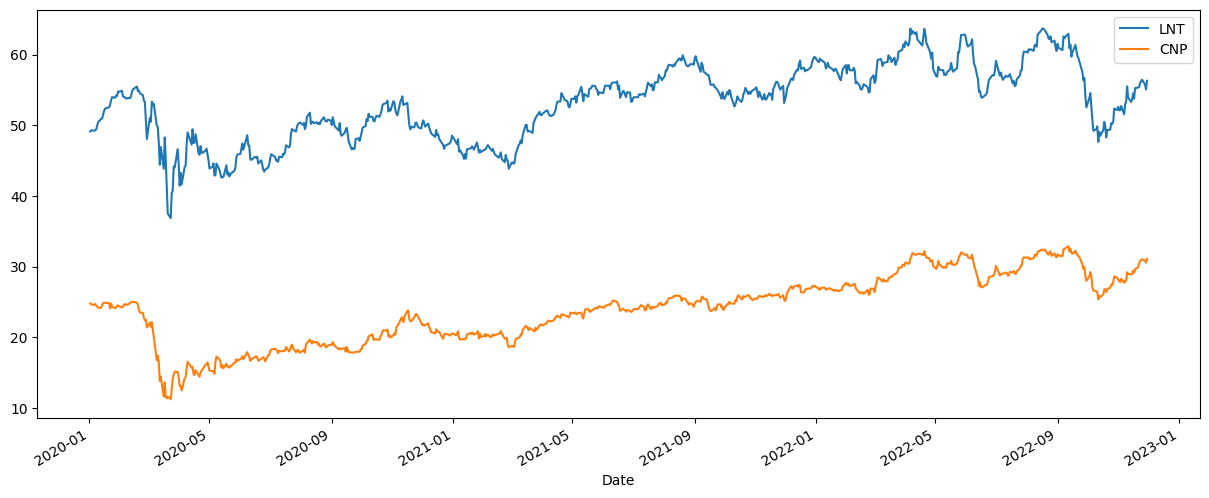

In [303]:
Asset1 = yf.download('LNT', start='2020-01-01', end='2022-12-01')
Asset1['Adj Close'].plot(figsize=(15,6),label='LNT')
Asset2 = yf.download('CNP', start='2020-01-01', end='2022-12-01')
Asset2['Adj Close'].plot(figsize=(15,6),label='CNP')
plt.legend()
plt.show()

## Graph the price spread and normalise data

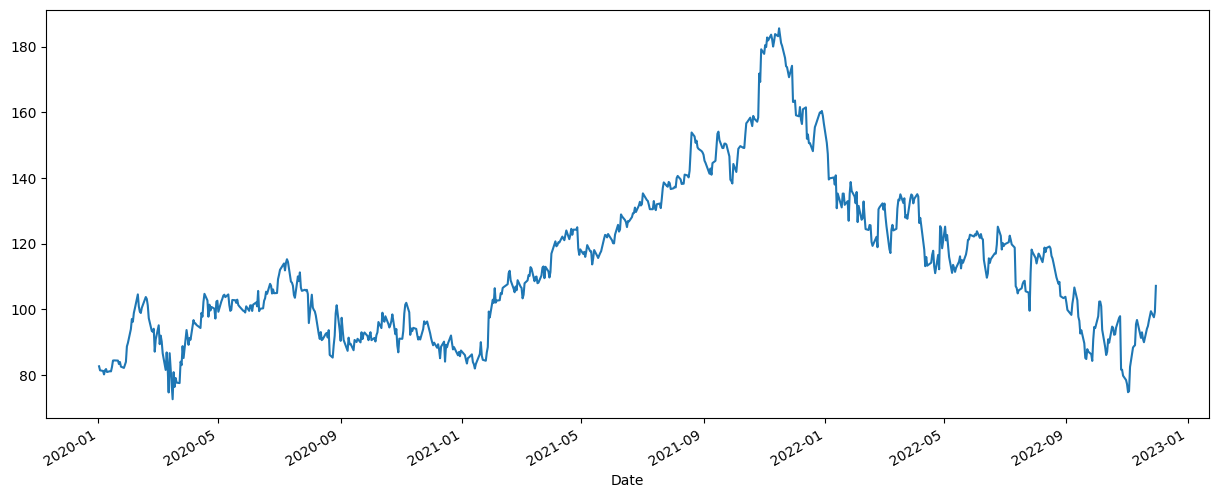

In [304]:
spread = np.abs(AAPL['Adj Close'] - MSFT['Adj Close'])
spread.plot(figsize=(15,6))
plt.show()

In [305]:
dates = pd.date_range('2020-01-01','2022-12-01',freq='B')
spread_df=df1.join(spread)

In [306]:
spread_df_norm=spread_df.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
spread_df_norm['Adj Close'] = scaler.fit_transform(spread_df_norm['Adj Close'].values.reshape(-1,1))
spread_df_norm.head()

,Adj Close
2021-01-04,-0.921046
2021-01-05,-0.947556
2021-01-06,-0.970570
2021-01-07,-0.938452
2021-01-08,-0.934785


## Separate data into trading testing sets and set your look back value

In [307]:
def data(asset, look_back):
    asset = asset
    data = []
    
    #All combinations of data given look back value
    for i in range(len(asset) - look_back): 
        data.append(asset[i: i + look_back])
    
    data = np.array(data);
    test_len = int(np.round(0.25*data.shape[0]));
    train_len = data.shape[0] - (test_len);
    
    x_train = data[:train_len,:-1,:]
    y_train = data[:train_len,-1,:]
    
    x_test = data[train_len:,:-1]
    y_test = data[train_len:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [356]:
look_back = 2 # choose sequence length
x_train, y_train, x_test, y_test = data(spread_df_norm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (345, 1, 1)
y_train.shape =  (345, 1)
x_test.shape =  (115, 1, 1)
y_test.shape =  (115, 1)


In [357]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [358]:
y_train.size(),x_train.size(),y_test.size(),x_test.size() #confirm dimensions so can set the correct parameters for neural network below


(torch.Size([345, 1]),
 torch.Size([345, 1, 1]),
 torch.Size([115, 1]),
 torch.Size([115, 1, 1]))

## Define LSTM model 
### I have adjusted hidden dimensions and number of layers by trial and error but see next file for more careful hyperparameter tuning
### I'm using Adam optimiser simply because that reduced the loss most effectively -> see further exploration in next code file

In [359]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() #make hidden state 0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #detach so can do truncated backprop 
        out = self.fc(out[:, -1, :]) 
        return out

In [360]:
input_dim = 1
hidden_dim = 10
num_layers = 5
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

LSTM(
  (lstm): LSTM(1, 10, num_layers=5, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


## Train model
### Will discuss optimal epochs next file

In [361]:
num_epochs = 100
hist = np.zeros(num_epochs)
seq_dim =look_back-1  

for t in range(num_epochs):
    y_train_prediction = model(x_train) #forward pass

    loss_ = loss(y_train_prediction, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch", t, "MSE: ", loss_.item())
    hist[t] = loss_.item()
    optimiser.zero_grad()
    loss_.backward() #backward pass
    optimiser.step() #update parameters

Epoch 10 MSE:  0.17908860743045807
Epoch 20 MSE:  0.17830140888690948
Epoch 30 MSE:  0.15284433960914612
Epoch 40 MSE:  0.03925873339176178
Epoch 50 MSE:  0.03346286341547966
Epoch 60 MSE:  0.020510492846369743
Epoch 70 MSE:  0.011909030377864838
Epoch 80 MSE:  0.008108562789857388
Epoch 90 MSE:  0.006127714179456234


## Training  Loss

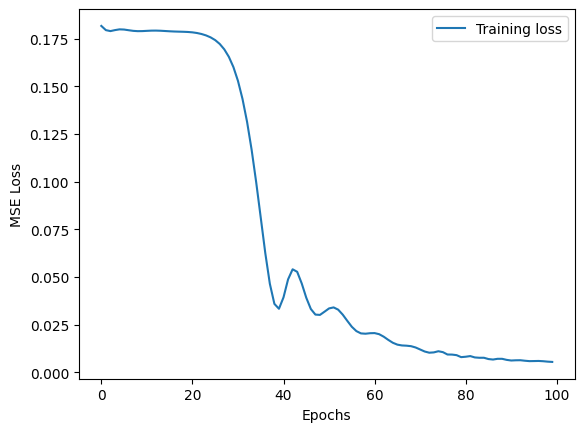

In [362]:
plt.plot(hist, label="Training loss")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [363]:
np.shape(y_train_prediction)

torch.Size([345, 1])

In [364]:

y_test_prediction = model(x_test)

y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train MSE Score:',trainScore)
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test MSE Score:', testScore)

Train MSE Score: 3.8054728549284342
Test MSE Score: 3.384756890586682


## Visualise the actual spread versus the predicted spread of test set

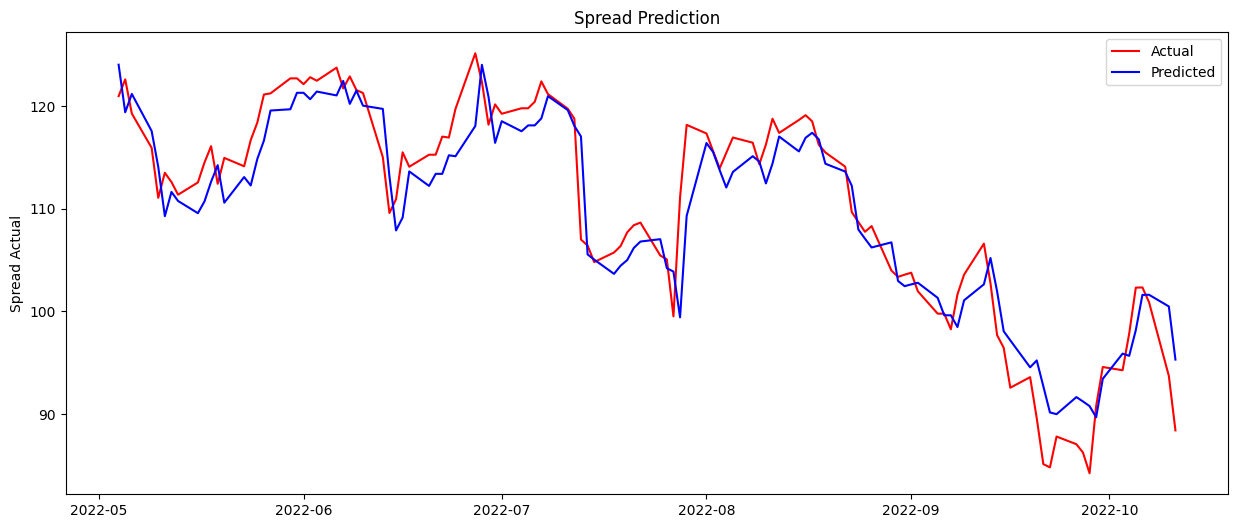

In [365]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction')
plt.ylabel('Spread Actual')
plt.legend()
plt.show()